In [6]:
!git clone https://github.com/annegnx/PnP-Flow.git

Cloning into 'PnP-Flow'...
remote: Enumerating objects: 747, done.
remote: Counting objects: 100% (86/86), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 747 (delta 62), reused 64 (delta 53), pack-reused 661 (from 1)
Receiving objects: 100% (747/747), 2.68 MiB | 6.32 MiB/s, done.
Resolving deltas: 100% (467/467), done.


# PnP-Flow demo

In [22]:
!pip install -e .

Obtaining file:///content/PnP-Flow
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.8/53.8 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.7/76.7 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 422.8/422.8 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 897.5/897.5 kB 56.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 343.2/343.2 kB 30.4 MB/s eta 0:00:00
  Building editable for pnpflow (pyproject.toml) ... done
  Created wheel for pnpflow: filename=pnpflow-0.1-0.editable-py3-none-any.whl size=3086 sha256=3307b626ffe64faab9c30cf47041689fc3ac7cdd251a6a8d456c45de85c03b8e
  Stored in directory: /tmp/pip-ephem-wheel-cache-nl2wq8qt/wheels/9d/cd/11/e432b3740001fa6d4ba4e0eb

In [1]:
from IPython.display import display, clear_output
from PIL import Image
import torch
import torchvision.transforms as v2
import matplotlib.pyplot as plt
import numpy as np
import sys
import os

# Add the cloned PnP-Flow directory to the system path
# Assuming the repository was cloned into a directory named 'PnP-Flow' in the current working directory
sys.path.append(os.path.abspath('PnP-Flow'))

from pnpflow.models import UNet

### Load pre-trained model on celeba

In [2]:
!pip install gdown
!gdown --id 1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6

/usr/local/lib/python3.11/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6
From (redirected): https://drive.google.com/uc?id=1ZZ6S-PGRx-tOPkr4Gt3A6RN-PChabnD6&confirm=t&uuid=1dedab77-d2c4-44a5-bb77-86c43c83d468
To: /content/model_final_celeba.pt
100% 138M/138M [00:01<00:00, 117MB/s]


In [3]:
model = UNet(input_channels=3,
             input_height=128,
             ch=32,
             ch_mult=(1, 2, 4, 8),
             num_res_blocks=6,
             attn_resolutions=(16, 8),
             resamp_with_conv=True,
             )

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load('model_final_celeba.pt', map_location=device))
model.to(device)
model.eval()

UNet(
  (act): Swish()
  (temb_net): TimestepEmbedding(
    (main): Sequential(
      (0): Linear(in_features=32, out_features=128, bias=True)
      (1): Swish()
      (2): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (begin_conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_modules): ModuleList(
    (0): ModuleDict(
      (0a_0a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1): GroupNorm(32, 32, eps=1e-06, affine=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 32, eps=1e-06, affine=True)
        (dropout): Identity()
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (shortcut): Identity()
      )
      (0a_1a_block): ResidualBlock(
        (act): Swish()
        (temb_proj): Linear(in_features=128, out_features=32, bias=True)
        (norm1)

## Load test image and inpaint it

In [27]:
image_path = 'PnP-Flow/demo/example.jpg'
clean_img = Image.open(image_path)

# Define the transformation
transform = v2.Compose([
    v2.Resize((512, 512)), # Add resize step
    v2.ToTensor(),
    v2.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# Apply the transformation
clean_img = transform(clean_img).unsqueeze(0).to(device)

In [28]:
# Create a random mask with 70% missing pixels
# Get the dimensions from the clean image tensor
height, width = clean_img.shape[-2:]
mask = np.random.rand(height, width) > 0.7
mask_tensor = torch.tensor(mask, dtype=torch.float32).unsqueeze(
    0).unsqueeze(0).to(device)

# define the linear operator H


def H(x):
    return x * mask_tensor


# Apply the mask to the image tensor and add noise
sigma_noise = 0.001
noisy_img = H(clean_img) + sigma_noise * torch.randn_like(clean_img)

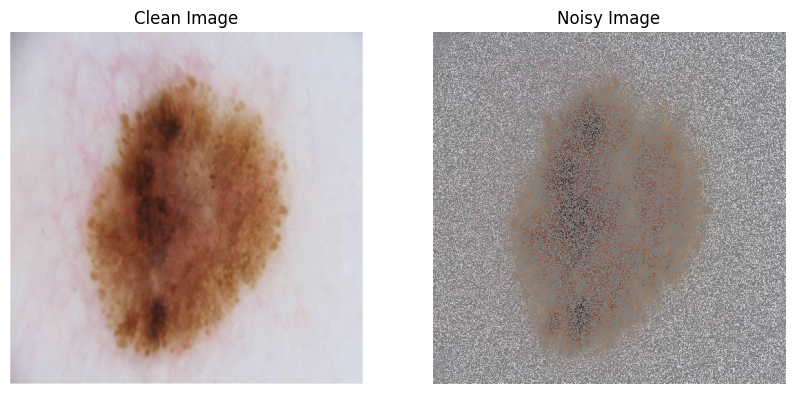

In [29]:
# plot the images
plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)
plt.imshow(torch.clip((clean_img[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0))
plt.axis('off')
plt.title('Clean Image')
plt.subplot(1, 2, 2)
plt.imshow(torch.clip((noisy_img[0].cpu() + 1) /
           2, 0, 1).permute(1, 2, 0), vmin=0, vmax=1)
plt.axis('off')
plt.title('Noisy Image')
plt.show()

## Restore it with PnP-flow

### Define denoiser

In [30]:
def denoiser(x, t):
    return x + (1 - t.view(-1, 1, 1, 1)) * model(x, t)

### Run PnP-Flow

Reconstructed image saved as PnP-Flow/demo/reconstructed_image.png


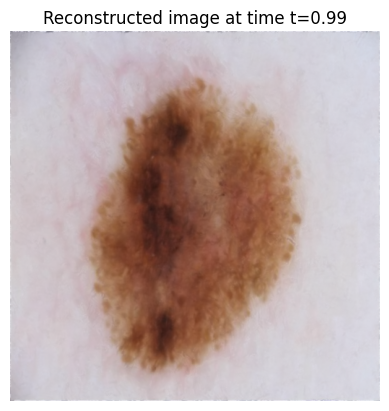

In [41]:
N = 100  # Number of time steps
alpha = 0.01  # Exponent in the learning rate
delta = 1 / N  # Time step size
# Initialize x with the same dimensions as the image and mask tensors
x = torch.zeros_like(clean_img).to(device)
fig, ax = plt.subplots()

for i in range(N):

    with torch.no_grad():

        t = torch.ones(len(x), device=device) * delta * i

        # Gradient step on the data-fidelity term
        lr_t = (1 - t)**alpha
        z = x - lr_t * H(H(x) - noisy_img)  # H is symmetric

        # Interpolation step
        z_tilde = t.view(-1, 1, 1, 1) * z + \
            torch.randn_like(x) * (1 - t.view(-1, 1, 1, 1))

        # Denoising step
        x_new = denoiser(z_tilde, t)

        # Update the solution
        x = x_new.clone()

        # Plot the current image
        if i % 5 == 0 or i == N - 1:
            clear_output(wait=True)
            ax.imshow(torch.clip((x[0].cpu() + 1) / 2,
                      0, 1).permute(1, 2, 0), vmin=0, vmax=1)
            ax.axis('off')
            ax.set_title(
                'Reconstructed image at time t={:4.2f}'.format(delta * i))
            display(fig)

clear_output(wait=False)

# Convert the final tensor to a PIL Image and save
output_img_tensor = torch.clip((x[0].cpu() + 1) / 2, 0, 1).permute(1, 2, 0)
output_img_np = output_img_tensor.numpy()
output_img_pil = Image.fromarray((output_img_np * 255).astype(np.uint8))
output_img_pil.save('PnP-Flow/demo/reconstructed_image.png')

print("Reconstructed image saved as PnP-Flow/demo/reconstructed_image.png")

In [32]:
!pip install clip-score

In [43]:
import os
import shutil

# Create temporary directories
os.makedirs('temp_real', exist_ok=True)
os.makedirs('temp_fake', exist_ok=True)

# Copy images to temporary directories
shutil.copy('PnP-Flow/demo/example.jpg', 'temp_real/')
shutil.copy('PnP-Flow/demo/reconstructed_image.png', 'temp_fake/')

# Run clip_score on the temporary directories
!python -m clip_score temp_real temp_fake --real_flag img --fake_flag img

# Clean up temporary directories
shutil.rmtree('temp_real')
shutil.rmtree('temp_fake')

2025-07-10 14:21:50.447345: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1752157310.467110   17460 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1752157310.473209   17460 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
Loading CLIP model: openai/clip-vit-base-patch32
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:943: FutureWarning: `resume_down